### import required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

### loading the dataset

In [3]:
df = pd.read_csv("dataset_dl.csv")
print("Dataset Shape:", df.shape)
print("\nFault type distribution:")
print(df['fault_type'].value_counts())

Dataset Shape: (29964, 5)

Fault type distribution:
fault_type
1    10320
2     9918
0     9726
Name: count, dtype: int64


### featue engineering

In [4]:
def correct_alu_operation(row):
    a = row['a']
    b = row['b']
    opcode = row['opcode']
    MASK = 0xFFFFFFFF

    if opcode == 0: return (a + b) & MASK
    elif opcode == 1: return (a - b) & MASK
    elif opcode == 2: return a & b
    elif opcode == 3: return a | b
    elif opcode == 4: return a ^ b
    else: return 0

df['correct_result'] = df.apply(correct_alu_operation, axis=1)
df['error_bits'] = df['faulty_result'] ^ df['correct_result']

print("Feature engineering complete. 'error_bits' column created.")
print(df[['faulty_result', 'correct_result', 'error_bits']].head())

Feature engineering complete. 'error_bits' column created.
   faulty_result  correct_result  error_bits
0     3533466277      3533466533         256
1       11555329        11555329           0
2      696988243       696988243           0
3       50577668        33800452    16777216
4      821665889       821665889           0


### prepare the data for 1D CNN

In [5]:
# Convert the 'error_bits' integer into a 32-item array (sequence) of bits
X_bits = np.array(
    df['error_bits'].apply(lambda x: [int(bit) for bit in f'{x:032b}']).tolist()
)

# Use the same labels
y = df['fault_type'].values

print("Shape of our new sequential features:", X_bits.shape)

Shape of our new sequential features: (29964, 32)


### train test split and reshape for CNN

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_bits, y, test_size=0.2, random_state=42, stratify=y
)

# Reshape data for the Conv1D layer: (samples, timesteps, features)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Shape of X_train for CNN:", X_train_cnn.shape)
print("Shape of X_test for CNN:", X_test_cnn.shape)

Shape of X_train for CNN: (23971, 32, 1)
Shape of X_test for CNN: (5993, 32, 1)


### build the CNN model

In [7]:
model_cnn = Sequential([
    # Convolutional layer to find local patterns (like a single flipped bit)
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(32, 1)),

    # Pooling layer to make patterns more robust
    MaxPooling1D(pool_size=2),

    # Another convolutional layer to learn more complex combinations of patterns
    Conv1D(filters=64, kernel_size=3, activation='relu'),

    # Flatten the output to feed into standard dense layers
    Flatten(),

    # Dense layers for final classification
    Dense(64, activation='relu'),
    Dropout(0.5),

    # Output layer for 3 classes
    Dense(3, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()

c:\Users\mithu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 13, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 832)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        53,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,843 (233.76 KB)

 Trainable params: 59,843 (233.76 KB)

 Non-trainable params: 0 (0.00 B)

### train the CNN model

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_cnn.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8706 - loss: 0.3499 - val_accuracy: 0.9102 - val_loss: 0.2066
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9196 - loss: 0.2021 - val_accuracy: 0.9257 - val_loss: 0.1734
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9239 - loss: 0.1825 - val_accuracy: 0.9257 - val_loss: 0.1709
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9247 - loss: 0.1782 - val_accuracy: 0.9257 - val_loss: 0.1710
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9236 - loss: 0.1802 - val_accuracy: 0.9262 - val_loss: 0.1725
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9247 - loss: 0.1768 - val_accuracy: 0.9262 - val_loss: 0.1690
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9253 - loss: 0.1754 - val_accuracy: 0.9262 - val_loss: 0.1692
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9247 - loss: 0.1763 - val_accuracy: 0.

### evaluate the model


Test Accuracy: 92.62%


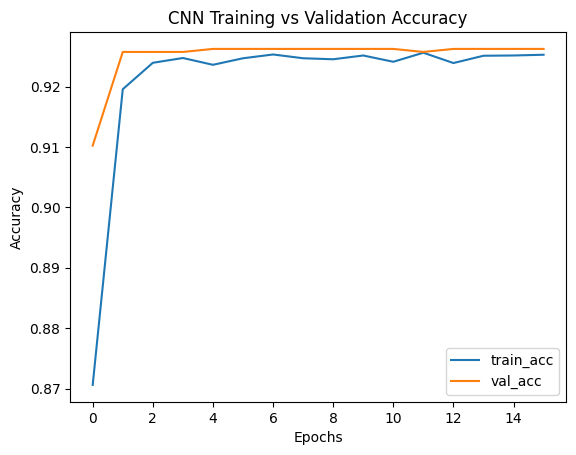

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


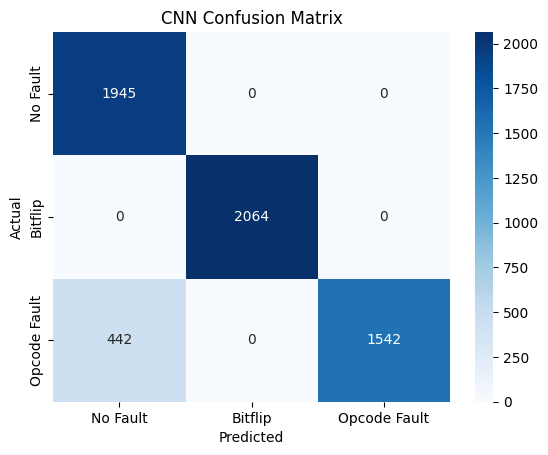


CNN Classification Report:
              precision    recall  f1-score   support

    No Fault       0.81      1.00      0.90      1945
     Bitflip       1.00      1.00      1.00      2064
Opcode Fault       1.00      0.78      0.87      1984

    accuracy                           0.93      5993
   macro avg       0.94      0.93      0.92      5993
weighted avg       0.94      0.93      0.93      5993



In [10]:
test_loss, test_acc = model_cnn.evaluate(X_test_cnn, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

# Plotting accuracy
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("CNN Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Confusion Matrix and Report
y_pred_cnn = np.argmax(model_cnn.predict(X_test_cnn), axis=1)
cm = confusion_matrix(y_test, y_pred_cnn)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Fault", "Bitflip", "Opcode Fault"],
            yticklabels=["No Fault", "Bitflip", "Opcode Fault"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CNN Confusion Matrix")
plt.show()

print("\nCNN Classification Report:")
print(classification_report(y_test, y_pred_cnn, target_names=["No Fault", "Bitflip", "Opcode Fault"]))

### this is the test data for testing myself

In [11]:
# --- SELF-CONTAINED TESTING CELL ---

# 1. DEFINE YOUR TEST DATA AND CLASS MAPPING
# You can modify or add your own test cases here!
test_data = np.array([
    # [Operand A, Operand B, Opcode, Faulty Result]
    # Case 1: Expected "No Fault" (Opcode 2 = AND)
    [100, 200, 2, 64],

    # Case 2: Expected "Bitflip" (Opcode 0 = ADD, result 300 has bit 10 flipped)
    [100, 200, 0, 1324],

    # Case 3: Expected "Opcode Fault" (Opcode 1 = SUB, but faulty result is from OR)
    [500, 150, 1, 503]
])

# Map model output index to a human-readable name
class_names = {0: "No Fault", 1: "Bitflip", 2: "Opcode Fault"}


# 2. RECREATE THE PREPROCESSING PIPELINE
# This must exactly match the one used for training.
def correct_alu_op(a, b, opcode):
    """A helper function to get the correct ALU result."""
    MASK = 0xFFFFFFFF
    if opcode == 0: return (a + b) & MASK
    if opcode == 1: return (a - b) & MASK
    if opcode == 2: return a & b
    if opcode == 3: return a | b
    if opcode == 4: return a ^ b
    return 0

# Calculate correct results and error_bits for the test data
correct_results = np.array([correct_alu_op(row[0], row[1], row[2]) for row in test_data])
error_bits_int = test_data[:, 3] ^ correct_results

# Convert error_bits integers to 32-bit sequences for the CNN
X_test_new = np.array(
    [ [int(bit) for bit in f'{x:032b}'] for x in error_bits_int]
)

# Reshape the data to match the CNN's input shape: (samples, timesteps, features)
X_test_new_cnn = X_test_new.reshape(X_test_new.shape[0], 32, 1)


# 3. MAKE PREDICTIONS WITH THE TRAINED MODEL
predictions = model_cnn.predict(X_test_new_cnn)
predicted_classes = np.argmax(predictions, axis=1)


# 4. DISPLAY THE RESULTS
print("--- Model Test Results ---")
for i, test_case in enumerate(test_data):
    pred_class_name = class_names[predicted_classes[i]]
    confidence = predictions[i][predicted_classes[i]] * 100
    
    print(f"\nTest Case #{i+1}:")
    print(f"  Input: A={test_case[0]}, B={test_case[1]}, Opcode={test_case[2]}, FaultyResult={test_case[3]}")
    print(f"  Error Bits: {error_bits_int[i]:032b}")
    print(f"  Predicted Fault: '{pred_class_name}' (Confidence: {confidence:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
--- Model Test Results ---

Test Case #1:
  Input: A=100, B=200, Opcode=2, FaultyResult=64
  Error Bits: 00000000000000000000000000000000
  Predicted Fault: 'No Fault' (Confidence: 74.93%)

Test Case #2:
  Input: A=100, B=200, Opcode=0, FaultyResult=1324
  Error Bits: 00000000000000000000010000000000
  Predicted Fault: 'Bitflip' (Confidence: 100.00%)

Test Case #3:
  Input: A=500, B=150, Opcode=1, FaultyResult=503
  Error Bits: 00000000000000000000000010101001
  Predicted Fault: 'Bitflip' (Confidence: 100.00%)


think it is end